In [3]:
import os
import sys
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Modeling Libraries
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

# Optimization & Validation
import optuna
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve

# Mute warnings
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)
sns.set_style("whitegrid")

# Define Paths
TRAIN_PATH = os.path.join('..', 'data', 'processed', '2dgp_train_features.parquet')
TEST_PATH = os.path.join('..', 'data', 'processed', '2dgp_test_features.parquet')

In [4]:
print("Loading data...")
train = pd.read_parquet(TRAIN_PATH)
test = pd.read_parquet(TEST_PATH)

# 1. Define Redundant Features to Drop
features_to_drop = [
    
]

# List of substrings to search for in column names
err_list = [
    
]

# Dynamically find columns that contain ANY string from err_list
error_features = [c for c in train.columns if any(e in c for e in err_list)]

print(f"Dropping {len(error_features)} error-related features: {error_features}")

# Combine lists (using set to avoid duplicates)
final_drop_list = list(set(features_to_drop + error_features))

# 3. Prepare X and y
# Drop IDs, Targets, and the combined list of features
X = train.drop(columns=['object_id', 'target', 'split', 'SpecType'] + final_drop_list, errors='ignore')
y = train['target']
object_ids_test = test['object_id']

# 4. Prepare Test Set (Align columns)
X_test = test.drop(columns=['object_id', 'split'] + final_drop_list, errors='ignore')
X_test = X_test.reindex(columns=X.columns, fill_value=0)

# 5. Clean Column Names for LightGBM
def clean_cols(df):
    return [re.sub(r'[^A-Za-z0-9_]+', '_', str(c)) for c in df.columns]

X.columns = clean_cols(X)
X_test.columns = clean_cols(X_test)

print(f"Data Loaded. Train Shape: {X.shape}")
print(f"Class Imbalance: {y.value_counts().to_dict()}")

Loading data...
Dropping 0 error-related features: []
Data Loaded. Train Shape: (3043, 288)
Class Imbalance: {0: 2895, 1: 148}


In [5]:
def objective_xgb(trial):
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'aucpr',
        'n_estimators': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 0.95),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.95),
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 10, 40),
        'early_stopping_rounds': 50,
        'n_jobs': -1,
        'random_state': 42
    }
    
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    f1_scores = []
    
    for tr_idx, val_idx in skf.split(X, y):
        X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]
        
        clf = xgb.XGBClassifier(**param)
        clf.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
        
        preds = clf.predict_proba(X_val)[:, 1]
        prec, rec, _ = precision_recall_curve(y_val, preds)
        f1 = 2 * (prec * rec) / (prec + rec + 1e-9)
        f1_scores.append(np.max(f1))
        
    return np.mean(f1_scores)

def objective_lgb(trial):
    param = {
        'objective': 'binary',
        'metric': 'average_precision',
        'n_estimators': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 0.95),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.95),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 10, 40),
        'n_jobs': -1,
        'random_state': 42,
        'verbosity': -1
    }
    
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    f1_scores = []
    
    for tr_idx, val_idx in skf.split(X, y):
        X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]
        
        clf = lgb.LGBMClassifier(**param)
        callbacks = [lgb.early_stopping(50, verbose=False)]
        clf.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], eval_metric='average_precision', callbacks=callbacks)
        
        preds = clf.predict_proba(X_val)[:, 1]
        prec, rec, _ = precision_recall_curve(y_val, preds)
        f1 = 2 * (prec * rec) / (prec + rec + 1e-9)
        f1_scores.append(np.max(f1))
        
    return np.mean(f1_scores)

def objective_cat(trial):
    param = {
        'iterations': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'random_strength': trial.suggest_float('random_strength', 1e-3, 10.0, log=True),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 10, 40),
        'eval_metric': 'PRAUC',
        'early_stopping_rounds': 50,
        'verbose': 0,
        'allow_writing_files': False,
        'random_seed': 42
    }
    
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    f1_scores = []
    
    for tr_idx, val_idx in skf.split(X, y):
        X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]
        
        clf = CatBoostClassifier(**param)
        clf.fit(X_tr, y_tr, eval_set=(X_val, y_val))
        
        preds = clf.predict_proba(X_val)[:, 1]
        prec, rec, _ = precision_recall_curve(y_val, preds)
        f1 = 2 * (prec * rec) / (prec + rec + 1e-9)
        f1_scores.append(np.max(f1))
        
    return np.mean(f1_scores)

In [ ]:
print("--- Optimizing XGBoost ---")
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=100)
print(f"Best XGB F1: {study_xgb.best_value:.4f}")

print("\n--- Optimizing LightGBM ---")
study_lgb = optuna.create_study(direction='maximize')
study_lgb.optimize(objective_lgb, n_trials=100)
print(f"Best LGB F1: {study_lgb.best_value:.4f}")

print("\n--- Optimizing CatBoost ---")
study_cat = optuna.create_study(direction='maximize')
study_cat.optimize(objective_cat, n_trials=40) # CatBoost is slower, fewer trials
print(f"Best Cat F1: {study_cat.best_value:.4f}")

--- Optimizing XGBoost ---
Best XGB F1: 0.5906

--- Optimizing LightGBM ---
Best LGB F1: 0.5867

--- Optimizing CatBoost ---
Best Cat F1: 0.5941


In [7]:
# Function to get robust OOF and Test predictions
def train_robust_model(model_type, best_params, X, y, X_test):
    n_splits = 5
    n_repeats = 3
    rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)
    
    oof_probs = np.zeros(len(y))
    test_probs = np.zeros(len(X_test))
    
    print(f"Training Robust {model_type}...")
    
    for fold, (train_idx, val_idx) in enumerate(rskf.split(X, y)):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        if model_type == 'XGB':
            params = best_params.copy()
            params.update({'n_estimators': 3000, 'n_jobs': -1, 'random_state': 42, 'early_stopping_rounds': 150, 'objective': 'binary:logistic', 'eval_metric': 'aucpr'})
            clf = xgb.XGBClassifier(**params)
            clf.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
            
        elif model_type == 'LGB':
            params = best_params.copy()
            params.update({'n_estimators': 3000, 'n_jobs': -1, 'random_state': 42, 'objective': 'binary', 'metric': 'average_precision', 'verbosity': -1})
            clf = lgb.LGBMClassifier(**params)
            callbacks = [lgb.early_stopping(150, verbose=False)]
            clf.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], eval_metric='average_precision', callbacks=callbacks)
            
        elif model_type == 'CAT':
            params = best_params.copy()
            params.update({'iterations': 3000, 'eval_metric': 'PRAUC', 'early_stopping_rounds': 150, 'verbose': 0, 'allow_writing_files': False, 'random_seed': 42})
            clf = CatBoostClassifier(**params)
            clf.fit(X_tr, y_tr, eval_set=(X_val, y_val))
            
        # Accumulate predictions
        oof_probs[val_idx] += clf.predict_proba(X_val)[:, 1]
        test_probs += clf.predict_proba(X_test)[:, 1]
        
        if (fold+1) % 5 == 0:
            print(f"Fold {fold+1}/{n_splits*n_repeats} complete.")
            
    # Average results
    oof_probs /= n_repeats
    test_probs /= (n_splits * n_repeats)
    
    return oof_probs, test_probs

# --- EXECUTE FINAL TRAINING ---
oof_xgb, test_xgb = train_robust_model('XGB', study_xgb.best_params, X, y, X_test)
oof_lgb, test_lgb = train_robust_model('LGB', study_lgb.best_params, X, y, X_test)
oof_cat, test_cat = train_robust_model('CAT', study_cat.best_params, X, y, X_test)

Training Robust XGB...
Fold 5/15 complete.
Fold 10/15 complete.
Fold 15/15 complete.
Training Robust LGB...
Fold 5/15 complete.
Fold 10/15 complete.
Fold 15/15 complete.
Training Robust CAT...
Fold 5/15 complete.
Fold 10/15 complete.
Fold 15/15 complete.


In [8]:
from scipy.optimize import minimize
from sklearn.metrics import precision_recall_curve
import numpy as np

# --- 1. Define Optimization Function ---
def maximize_f1(weights):
    # Normalize weights so they sum to 1
    weights = np.array(weights)
    if np.sum(weights) == 0: return 0 # Safety
    weights /= np.sum(weights)
    
    # Create Weighted Probability
    ensemble_prob = (weights[0] * oof_xgb) + (weights[1] * oof_lgb) + (weights[2] * oof_cat)
    
    # Calculate Precision/Recall
    precision, recall, thresholds = precision_recall_curve(y, ensemble_prob)
    
    # Slice to avoid length mismatch
    f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-12)
    
    return -np.max(f1_scores)

# --- 2. Robust Optimization Loop ---
print("Optimizing with Nelder-Mead (Gradient-Free)...")

models = ['XGB', 'LGB', 'CAT']
best_score = 1.0
best_weights = [1/3, 1/3, 1/3]

# Try 5 different random starting points to avoid getting stuck
np.random.seed(42)
starting_points = [
    [1/3, 1/3, 1/3],  # Equality
    [0.8, 0.1, 0.1],  # XGB bias
    [0.1, 0.8, 0.1],  # LGB bias
    [0.1, 0.1, 0.8],  # CAT bias
    np.random.dirichlet(np.ones(3)) # Pure random
]

for i, init_w in enumerate(starting_points):
    # Nelder-Mead handles noisy/flat functions better than SLSQP
    res = minimize(maximize_f1, init_w, method='Nelder-Mead', 
                   bounds=((0,1), (0,1), (0,1)), tol=1e-4)
    
    if res.fun < best_score:
        best_score = res.fun
        best_weights = res.x
        print(f"Found better weights at Run {i+1}: {best_weights / np.sum(best_weights)}")

# Normalize Final Weights
final_w = best_weights / np.sum(best_weights)

print("\n--- Final Optimized Weights ---")
print(f"XGBoost Weight:  {final_w[0]:.4f}")
print(f"LightGBM Weight: {final_w[1]:.4f}")
print(f"CatBoost Weight: {final_w[2]:.4f}")
print(f"Max Optimized F1: {-best_score:.4f}")

# --- 3. Apply & Check Threshold ---
oof_ensemble_weighted = (final_w[0] * oof_xgb) + (final_w[1] * oof_lgb) + (final_w[2] * oof_cat)
test_probs_weighted = (final_w[0] * test_xgb) + (final_w[1] * test_lgb) + (final_w[2] * test_cat)

# Recalculate Best Threshold
p, r, t = precision_recall_curve(y, oof_ensemble_weighted)
f1 = 2 * (p[:-1] * r[:-1]) / (p[:-1] + r[:-1] + 1e-12)
best_thresh_weighted = t[np.argmax(f1)]

print(f"New Optimal Threshold: {best_thresh_weighted:.4f}")

# --- 4. Submit ---
test_preds_binary = (test_probs_weighted >= best_thresh_weighted).astype(int)

submission = pd.DataFrame({
    'object_id': object_ids_test,
    'prediction': test_preds_binary
})
submission.to_csv('submission.csv', index=False)
print("Saved 'submission.csv'")

Optimizing with Nelder-Mead (Gradient-Free)...
Found better weights at Run 1: [0.32786885 0.3442623  0.32786885]
Found better weights at Run 3: [0.09615385 0.80769231 0.09615385]
Found better weights at Run 5: [0.09784297 0.62761396 0.27454307]

--- Final Optimized Weights ---
XGBoost Weight:  0.0978
LightGBM Weight: 0.6276
CatBoost Weight: 0.2745
Max Optimized F1: 0.6040
New Optimal Threshold: 0.3636
Saved 'submission.csv'


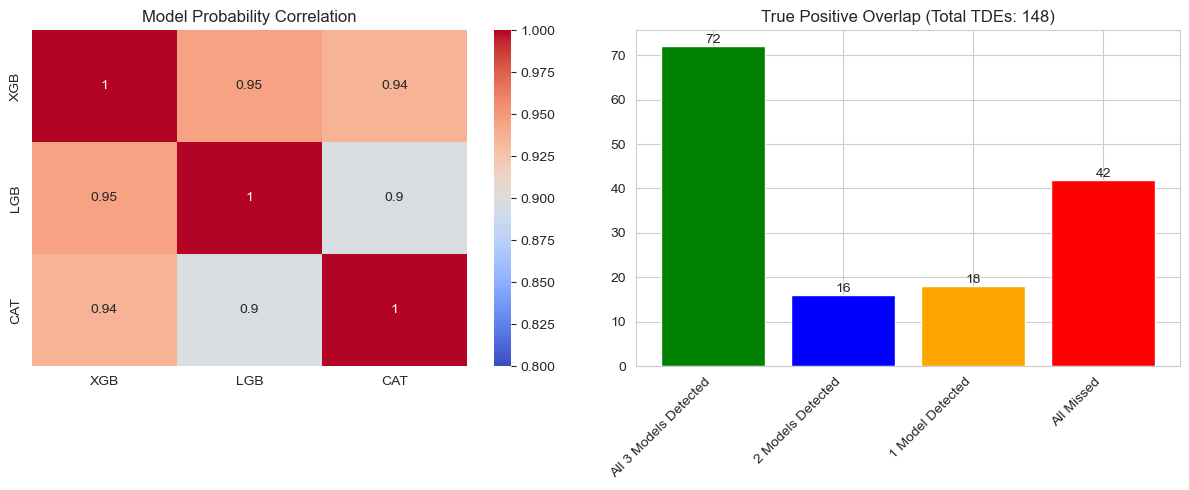

--- Overlap Insights ---
If '1 Model Detected' is high, your models are finding DIFFERENT TDEs (Ensemble will help a lot).
If 'All 3 Models Detected' is high, your models are very similar (Ensemble will stabilize but not boost score much).


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# --- 1. Correlation Heatmap (Probability Rank Alignment) ---
probs_df = pd.DataFrame({
    'XGB': oof_xgb,
    'LGB': oof_lgb,
    'CAT': oof_cat
})

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(probs_df.corr(), annot=True, cmap='coolwarm', vmin=0.8, vmax=1.0)
plt.title("Model Probability Correlation")

# --- 2. Binary Overlap (Decision Agreement) ---
# Apply the best threshold to see which models 'flagged' a TDE
binary_df = pd.DataFrame({
    'XGB': (oof_xgb >= best_thresh_weighted).astype(int),
    'LGB': (oof_lgb >= best_thresh_weighted).astype(int),
    'CAT': (oof_cat >= best_thresh_weighted).astype(int)
})

# Calculate Agreement
binary_df['Sum'] = binary_df.sum(axis=1) # 3 = All agree, 0 = None agree
binary_df['Target'] = y.reset_index(drop=True)

# Count overlaps
all_agree = len(binary_df[(binary_df['Sum'] == 3) & (binary_df['Target'] == 1)])
two_agree = len(binary_df[(binary_df['Sum'] == 2) & (binary_df['Target'] == 1)])
one_agree = len(binary_df[(binary_df['Sum'] == 1) & (binary_df['Target'] == 1)])
missed    = len(binary_df[(binary_df['Sum'] == 0) & (binary_df['Target'] == 1)])

# Visual Bar Chart
plt.subplot(1, 2, 2)
categories = ['All 3 Models Detected', '2 Models Detected', '1 Model Detected', 'All Missed']
counts = [all_agree, two_agree, one_agree, missed]
bars = plt.bar(categories, counts, color=['green', 'blue', 'orange', 'red'])
plt.title(f"True Positive Overlap (Total TDEs: {sum(y)})")
plt.xticks(rotation=45, ha='right')
plt.bar_label(bars)

plt.tight_layout()
plt.show()

print("--- Overlap Insights ---")
print("If '1 Model Detected' is high, your models are finding DIFFERENT TDEs (Ensemble will help a lot).")
print("If 'All 3 Models Detected' is high, your models are very similar (Ensemble will stabilize but not boost score much).")

Found 42 TDEs missed by all models.
Searching raw files for 5 objects...

--- DIAGNOSING 5 MISSED TDEs ---


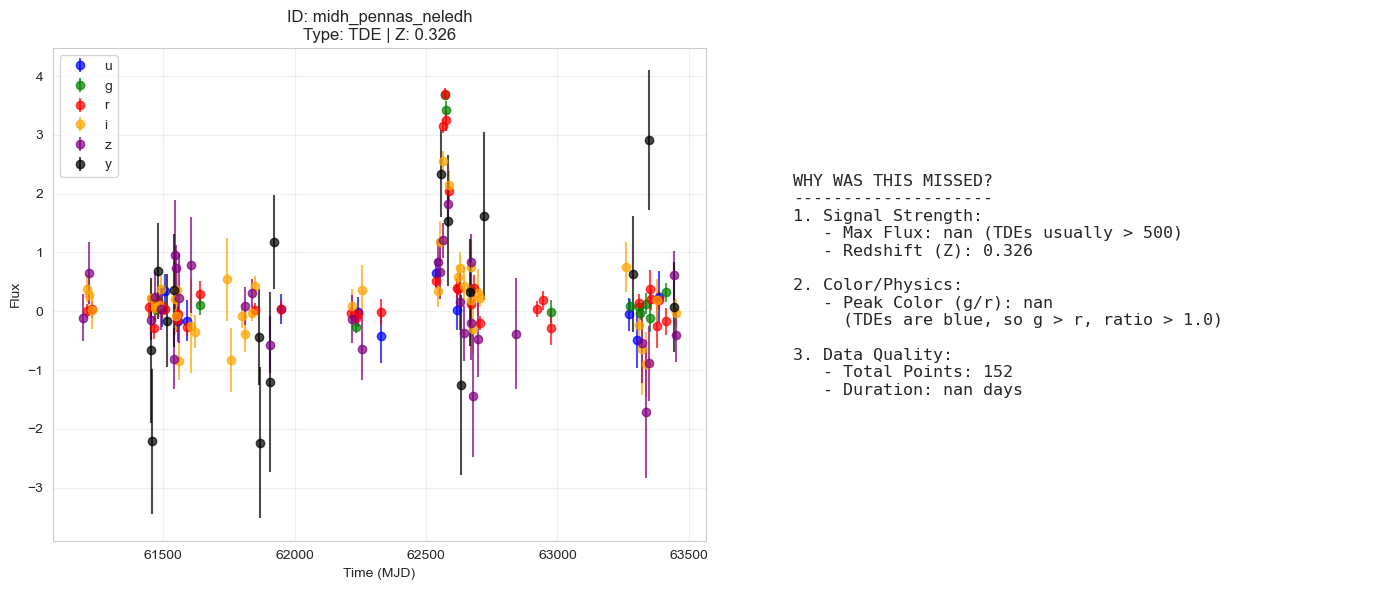

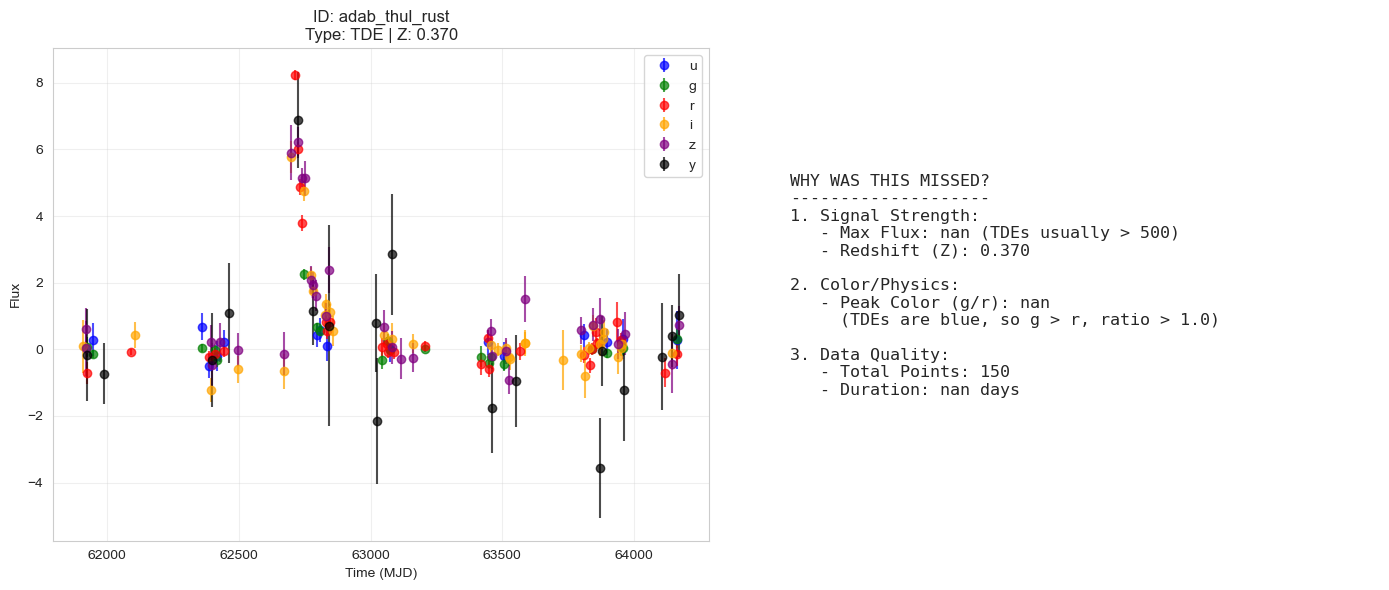

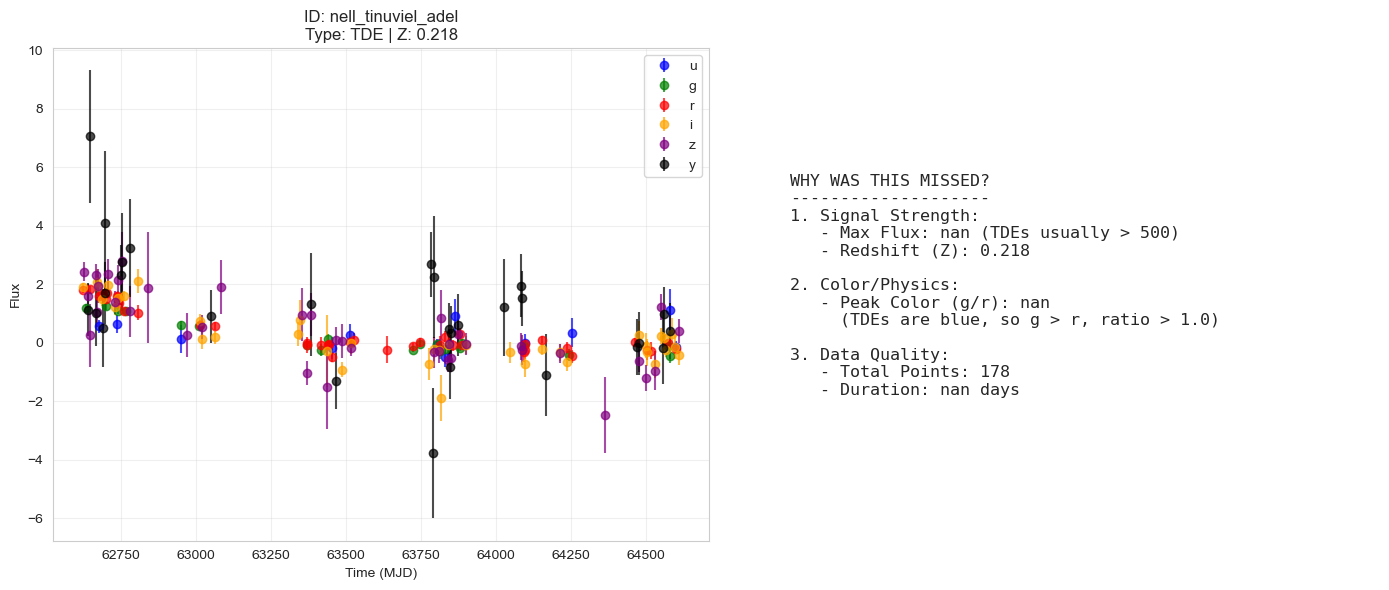

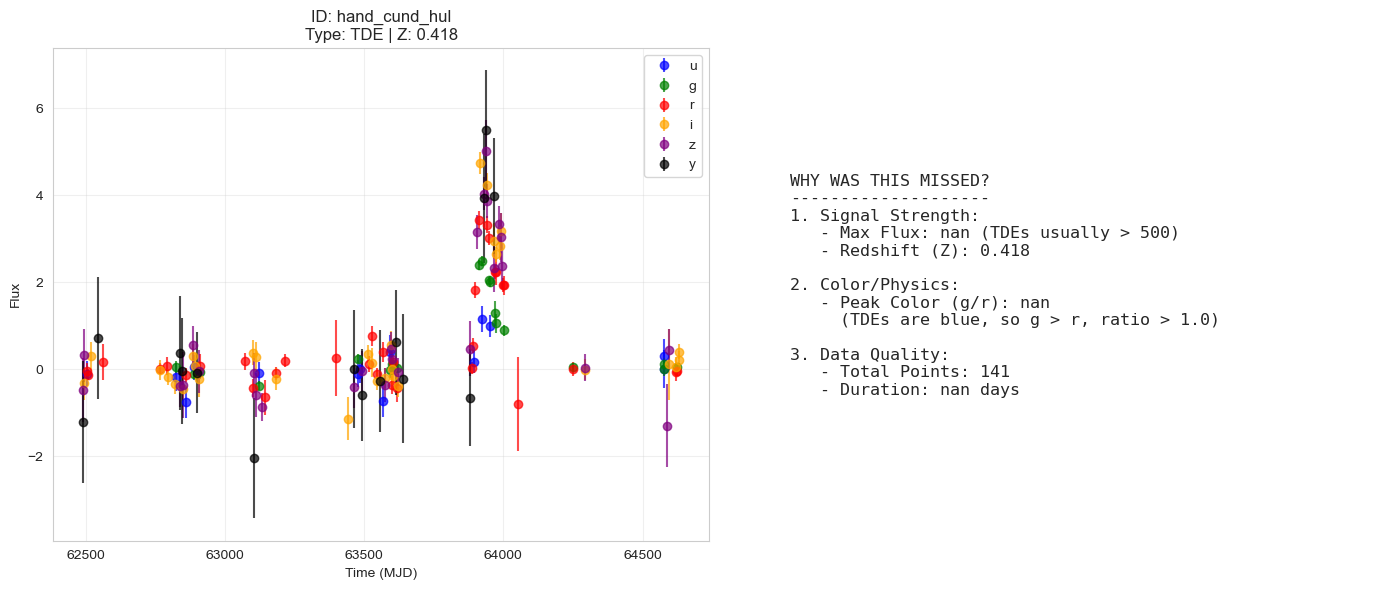

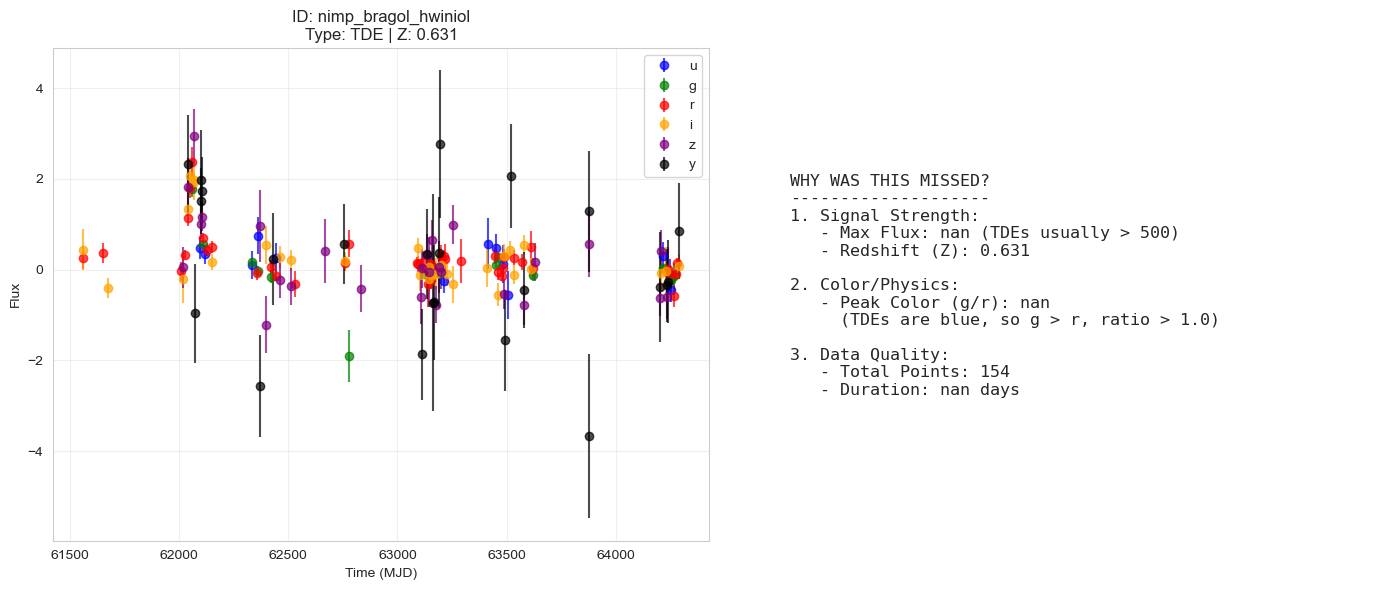

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import random

SEED = 15
np.random.seed(SEED)
random.seed(SEED)

# === 1. IDENTIFY THE 45 MISSED TDEs ===
# We need to reconstruct the agreement logic to find the specific IDs
# Use the best threshold found in the previous step
thresh = best_thresh_weighted

# Create binary predictions for each model individually
pred_xgb = (oof_xgb >= thresh).astype(int)
pred_lgb = (oof_lgb >= thresh).astype(int)
pred_cat = (oof_cat >= thresh).astype(int)

# Identify objects missed by ALL models (Sum = 0) but are actually TDEs (Target = 1)
agreement_sum = pred_xgb + pred_lgb + pred_cat
missed_mask = (agreement_sum == 0) & (y == 1)

# Get their Object IDs
missed_ids = train.loc[missed_mask, 'object_id'].values
print(f"Found {len(missed_ids)} TDEs missed by all models.")

# === 2. LOAD METADATA (SpecType) ===
# We dropped SpecType from 'train' earlier, so reload it from the log file
raw_path = Path("../data/raw")
log_df = pd.read_csv(raw_path / "train_log.csv")
# Create a quick lookup for SpecType and Redshift
meta_lookup = log_df.set_index('object_id')[['SpecType', 'Z', 'EBV']]

# === 3. RAW DATA LOADER ===
def get_lightcurves_from_raw(target_ids, base_path):
    """
    Scans split folders to find the raw lightcurves for specific IDs.
    """
    found_dfs = {}
    target_set = set(target_ids)
    
    print(f"Searching raw files for {len(target_ids)} objects...")
    
    # Iterate through the 20 splits
    for i in range(1, 21):
        if not target_set: break # Stop if we found everyone
        
        folder = f"split_{i:02d}"
        file_path = base_path / folder / "train_full_lightcurves.csv"
        
        if not file_path.exists(): continue
            
        # Optimization: Read only object_id first to see if we need this file
        try:
            # Read full chunk
            chunk = pd.read_csv(file_path)
            
            # Filter for our targets
            matches = chunk[chunk['object_id'].isin(target_set)]
            
            if not matches.empty:
                for obj_id in matches['object_id'].unique():
                    found_dfs[obj_id] = matches[matches['object_id'] == obj_id]
                    target_set.discard(obj_id) # Remove from search list
                    
        except Exception as e:
            print(f"Skipping {folder} due to error: {e}")
            
    return found_dfs

# Select 5 random missed objects to plot
sample_size = min(5, len(missed_ids))
sample_ids = np.random.choice(missed_ids, sample_size, replace=False)

# Load their data
lightcurves = get_lightcurves_from_raw(sample_ids, raw_path)

# === 4. DIAGNOSTIC PLOTTING ===
def plot_diagnostic(obj_id, df, train_features, metadata):
    plt.figure(figsize=(14, 6))
    
    # Extract Context
    spec_type = metadata.loc[obj_id, 'SpecType'] if obj_id in metadata.index else "Unknown"
    z = metadata.loc[obj_id, 'Z'] if obj_id in metadata.index else 0
    
    # Extract Model Features (What did the model see?)
    # We grab the specific row from the processed X dataframe
    feat_row = train_features[train_features['object_id'] == obj_id].iloc[0]
    
    # Key features that drive TDE detection
    peak_color = feat_row.get('peak_color_g_r', np.nan)
    duration = feat_row.get('duration_proxy', np.nan)
    flux_max = feat_row.get('Flux_corr_max', np.nan)
    
    # 1. Lightcurve Plot
    plt.subplot(1, 2, 1)
    colors = {'u': 'blue', 'g': 'green', 'r': 'red', 'i': 'orange', 'z': 'purple', 'y': 'black'}
    
    for band in ['u', 'g', 'r', 'i', 'z', 'y']:
        band_mask = df['Filter'] == f"Band {band}"
        if not band_mask.any(): band_mask = df['Filter'] == band # Try alt naming
        
        band_data = df[band_mask]
        if len(band_data) > 0:
            plt.errorbar(band_data['Time (MJD)'], band_data['Flux'], 
                         yerr=band_data['Flux_err'], fmt='o', 
                         label=band, color=colors.get(band, 'gray'), alpha=0.7)
            
    plt.title(f"ID: {obj_id}\nType: {spec_type} | Z: {z:.3f}")
    plt.xlabel("Time (MJD)")
    plt.ylabel("Flux")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 2. Text Stats Panel
    plt.subplot(1, 2, 2)
    plt.axis('off')
    
    info_text = (
        f"WHY WAS THIS MISSED?\n"
        f"--------------------\n"
        f"1. Signal Strength:\n"
        f"   - Max Flux: {flux_max:.2f} (TDEs usually > 500)\n"
        f"   - Redshift (Z): {z:.3f}\n\n"
        f"2. Color/Physics:\n"
        f"   - Peak Color (g/r): {peak_color:.2f}\n"
        f"     (TDEs are blue, so g > r, ratio > 1.0)\n\n"
        f"3. Data Quality:\n"
        f"   - Total Points: {len(df)}\n"
        f"   - Duration: {duration} days\n"
    )
    
    plt.text(0.1, 0.5, info_text, fontsize=12, family='monospace', va='center')
    
    plt.tight_layout()
    plt.show()

# Run the plotter
print(f"\n--- DIAGNOSING {sample_size} MISSED TDEs ---")
for obj_id in sample_ids:
    if obj_id in lightcurves:
        # We need to pass the training features to see what the model saw
        # Ensure 'train' has object_id column or index reset
        plot_diagnostic(obj_id, lightcurves[obj_id], train, meta_lookup)
    else:
        print(f"Data not found for {obj_id}")